В этом ноутбуке я хочу построить связь между обычным градиентным спуском и числом обусловленности матрицы-датасета. Давайте на разных примерах обучим нашу нейронную сеть и увидим все своими глазами.

Возьмем квадратичную зависимость по одному признаку и линейную по другой

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
np.random.seed(0)
N = 200
X = np.random.uniform(-2, 2, size=(N, 2)) 
y = X[:,0]**2 + X[:,0]*4 + 3*X[:,1] +  0.1 * np.random.random(N) 


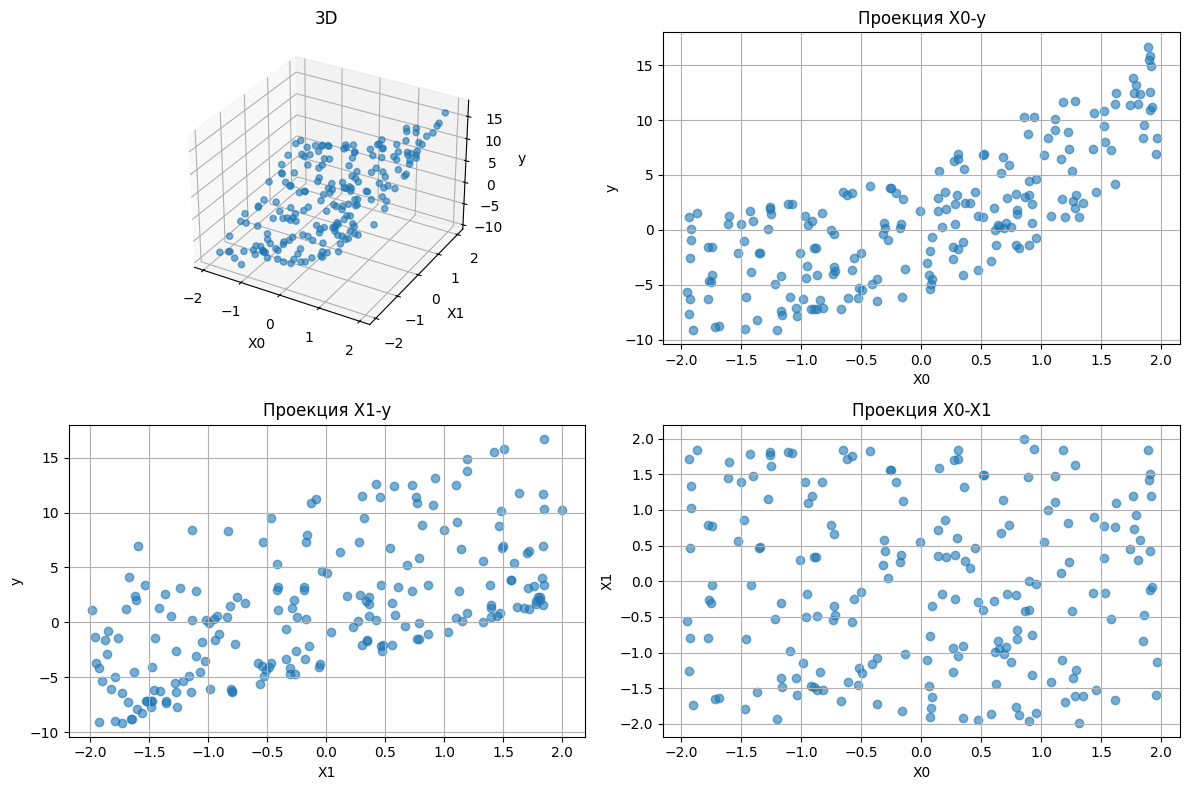

In [3]:
fig = plt.figure(figsize=(12, 8))


ax = fig.add_subplot(221, projection='3d')
ax.scatter(X[:,0], X[:,1], y, alpha=0.6)
ax.set_xlabel('X0')
ax.set_ylabel('X1') 
ax.set_zlabel('y')
ax.set_title('3D')


ax1 = fig.add_subplot(222)
ax1.scatter(X[:,0], y, alpha=0.6)
ax1.set_xlabel('X0')
ax1.set_ylabel('y')
ax1.set_title('Проекция X0-y')
ax1.grid(True)


ax2 = fig.add_subplot(223)
ax2.scatter(X[:,1], y, alpha=0.6)
ax2.set_xlabel('X1')
ax2.set_ylabel('y')
ax2.set_title('Проекция X1-y')
ax2.grid(True)


ax3 = fig.add_subplot(224)
ax3.scatter(X[:,0], X[:,1], alpha=0.6)
ax3.set_xlabel('X0')
ax3.set_ylabel('X1')
ax3.set_title('Проекция X0-X1')
ax3.grid(True)

plt.tight_layout()
plt.show()

In [4]:
y = y.reshape(200,1)

In [5]:
import sys
sys.path.append('..')

from engine.Tensor import Tensor
from engine.graph import draw_dot
import engine.nn as nn
from engine.Optims import GradientDescent

Напишем простую однослойную нейросеть 

In [6]:
class NN(nn.Module):
    def __init__(self, ):
        super().__init__()
        hidden1 = nn.Linear(2,2)
        relu = nn.ReLu()
        out = nn.Linear(2,1)
        self.seq = nn.Sequential(hidden1, relu, out)

    def parameters(self):
        return self.seq.parameters()
    
    def forward(self, X):
        return self.seq(X)


In [7]:
model = NN()

Посмотрим число обусловленности входной матрицы

In [8]:
np.linalg.cond(X)

np.float64(1.057284237305021)

Видим, что оно очень близко к единице

Начнем обучение нашей модели

In [9]:
epochs = 1000
L1 = nn.L1()
optim = GradientDescent(model.parameters(), lr=0.01)
trajectory = []
for epoch in range(epochs):
    pred = model(X)
    loss = L1(pred, y)
    print(loss)
    loss.zero_grad()
    loss.backward()
    trajectory.append(model.seq.layers[0].W.data.copy())
    optim.step()
    


5.321317263301676
5.298040357756902
5.275228282388266
5.252562525434813
5.230382336055542
5.20829772066246
5.186305761720239
5.164403553497325
5.142588201681401
5.120860071892016
5.099219678034449
5.0776716110148525
5.056603988687409
5.035907852838319
5.0152880259806345
4.995280065863979
4.975936762170541
4.95669206901894
4.938142418083219
4.920172680021006
4.902402252774848
4.884666839655489
4.866964764705457
4.849303829214472
4.831672149364549
4.8140677285847815
4.796522647080028
4.779331186134069
4.76204879796899
4.745359989336194
4.729320382900604
4.713956103801268
4.699972762870364
4.686207299929932
4.672776230923379
4.66028408498738
4.6477811899385335
4.635259117249745
4.6228605946794765
4.610842552661175
4.599479125580114
4.5884661091463546
4.577533724329568
4.56694097343568
4.556645535493579
4.546323441462541
4.536247175742284
4.526583944257519
4.517092950672553
4.5079617398392955
4.499080140588586
4.490261417689972
4.481592541888615
4.473267716359546
4.464920350862887
4.456934

Лосс сильно уменьшился. А значит, градиентный спуск сработал успешно. Почему бы не посмотреть на числа обусловленности после каждого слоя нашей нейронной сети?

In [10]:
l = ['input','hidden1', 'relu', 'out']
print("число обусловленности")
for i in range(len(l)):
    cond = np.linalg.cond(model.seq.stop_on(X,i).data)
    print(f'после {l[i]}: \t {cond}')

число обусловленности
после input: 	 1.057284237305021
после hidden1: 	 4.028291113751845
после relu: 	 1.1311537353468066
после out: 	 1.0


Везде оно не сильно большое. Скрытый слой создает много мультиколлинеарных векторов, из-за чего cond подскакивает до 5, но судя по тому, что после ReLU он падает, скорее всего первый линейный слой выдавал векторы с корреляцией -1. ReLU обнулил те из них, что отрицательные, и cond вернулся к единичке. Но ReLU не всемогущий. могло же появиться много векторов с corr=1. Давайте покажу на примере

Поменяем модель. Сделаем ее очень неадекватной, чтобы лучше увидеть проблему. Пусть в нашем линейном слое будет не 2 нейрона, а, например 9999. Тогда мультиколлинеарных векторов будет куда больше

In [11]:
class BAD_NN(nn.Module):
    def __init__(self, ):
        super().__init__()
        hidden1 = nn.Linear(2,9999)
        relu = nn.ReLu()
        out = nn.Linear(9999,1)
        self.seq = nn.Sequential(hidden1, relu, out)

    def parameters(self):
        return self.seq.parameters()
    
    def forward(self, X):
        return self.seq(X)
model = BAD_NN()

In [12]:
epochs = 50
L1 = nn.L1()
optim = GradientDescent(model.parameters(), lr=0.001)
trajectory = []
for epoch in range(epochs):
    pred = model(X)
    loss = L1(pred, y)
    print(loss)
    loss.zero_grad()
    loss.backward()
    trajectory.append(model.seq.layers[0].W.data.copy())
    optim.step()
    

4.391340400691478
2.3195850908674207
1.3955018307571145
1.8566809108107345
2.7066860687098573
1.9699508641842045
2.706684478215425
1.9699478090871325
2.706682887732425
1.9699447539577284
2.7066812973271692
1.9699416988301652
2.7066797069230795
1.9699386436831328
2.70667811622371
1.9699355889092323
2.7066765255277345
1.9699325341365965
2.7066749348351533
1.9699294793652273
2.706673344165913
1.9699264241292143
2.7066717539565492
1.9699233689016016
2.7066701637261334
1.969920313708343
2.7066685734975637
1.9699172585178968
2.706666983270843
1.9699142033302623
2.70666539304597
1.9699111481454412
2.7066638028229444
1.9699080929634312
2.706662212601766
1.9699050377842338
2.706660622382436
1.9699019826078488
2.7066590321649535
1.9698989274342757
2.7066574419436398
1.9698958720767474
2.7066558516540535
1.9698928169758363
2.7066542613654216
1.9698897618786293
2.7066526710777463
1.969886706785127
2.706651080791027
1.9698836516953282


Мало того, что для расчета градиента размером 2x9999 требуется куча времени, так еще и градиент не сходится. Почему? Давайте снова посмотрим обусловленности 

In [13]:
l = ['input','hidden1', 'relu', 'out']
print("число обусловленности")
for i in range(len(l)):
    cond = np.linalg.cond(model.seq.stop_on(X,i).data)
    print(f'после {l[i]}: \t {cond}')

число обусловленности
после input: 	 1.057284237305021
после hidden1: 	 8.655539289950258e+17
после relu: 	 11759469.800257767
после out: 	 1.0


И здесь уже скрытый слой создает столько бессмысленных векторов, что даже ReLU не справляется 

В целом, хорошая обусловленность матриц - не единственное и не главное условие для быстрого схождения обычного градиентного спуска. Сильно роляют начальная точка весов, шаг обучения, структура функции лосса. В этом ноутбуке я лишь рассмотрел влияние обусловленностей матриц на скорость сходимости. Это не закрепляет никакой прямой зависимости между 